# Yaki-imo DX Heater control algs.
 Since, we have several heater control algorithms. Typically, OnOff-Controller, PID-Controller as well.

## Cycle controller
 Cycle controller generates almost fixed output. Ofcourse, open-loop controller is not robust disturburance.

### Purpose
 Look for parameters for good-taste :-)

### Flexible stages design
 Should do following steps...

0. Dummy for alignment
1. Warm-up: 300sec
2. Glycation: 3600sec (60-80℃).
3. Stabilization: 1800sec.
4. Finish: 1800sec.


In [1]:
# Common part... Should be done at start-up

import serial  
import time  
import datetime  
import numpy as np
from matplotlib import pyplot as plt

x_list = []
y_chamberlist = []
y_bodylist = []
y_heaterstatus = []
x_list.append(0)
y_chamberlist.append(0)
y_bodylist.append(0)
y_heaterstatus.append(0)

TempGlycation = 60
StageOffTemp = [75, 80, 100, 80]
StageOnTime = [0.75, 0.5, 0.75, 0.6]
StagePeriod = [300, 3600, 1800, 1800]
StageMessage = ["Warm-up", "Glycation", "Stabilization", "Finish"]

ser = serial.Serial('/dev/ttyACM0', baudrate=9600, parity=serial.PARITY_NONE)
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')

## Cycle-Controller
 Duty cycle in every peridic-task(=1sec).

In [2]:
def GSCycleController(aStage):
    print ('%s: Period = %d [sec] Heater On/Off cycle = %f/%f' % (StageMessage[aStage], StagePeriod[aStage], StageOnTime[aStage], 1.0 - StageOnTime[aStage]))

    i = 0
    for i in range(StagePeriod[aStage]):
        print ('%04d ' % i, end="")

        now = datetime.datetime.now(JST)
        d = now.strftime('%Y/%m/%d-%H:%M:%S')
        print(d, end=" ")  # 2021/11/04 17:37:28

        ser.write(str.encode("0"))
        tempChamberStr = ser.readline().strip().decode('utf-8')

        ser.write(str.encode("1"))
        tempBodyStr = ser.readline().strip().decode('utf-8')

        if tempChamberStr == "NC":
            print ("Sensor is not working !!")
            print ("Operation is terminated !!")
            ser.write(str.encode("a"))
            break;
        else:
            tempChamberInt = int(tempChamberStr)
            tempBodyInt = int(tempBodyStr)
            print ("%03d℃ %03d℃" % (tempChamberInt, tempBodyInt), end = " ")

#
# --- Your logic is here. ---
#
            # Heater-On
            if (tempChamberInt < StageOffTemp[aStage]):
                ser.write(str.encode("A"))
                heaterStatus = 1

            else:
                heaterStatus = 0

            print (heaterStatus)
            time.sleep(StageOnTime[aStage])

            # Heater-Off
            ser.write(str.encode("a"))

#
# --- End of your logic. ---
#
        
        y_chamberlist.append(tempChamberInt)
        y_bodylist.append(tempBodyInt)
        y_heaterstatus.append(heaterStatus)
        
        time.sleep(1.0 - StageOnTime[aStage])

    ser.write(str.encode("a"))


7500


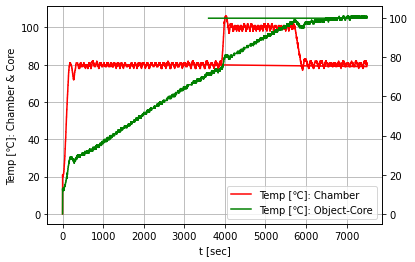

In [9]:
# def plot():
i = 0
t = 0
for i in range(len(StagePeriod)):
    t += StagePeriod[i]
print (t)

i = 0
for i in range(t):
    x_list[i] = i

fig = plt.figure()
ax1 = fig.add_subplot(111)
fs = 1.0
ln1 = ax1.plot(x_list, y_chamberlist, color="r", label='Temp [℃]: Chamber') #line in red

ax2 = ax1.twinx()
ln2 = ax2.plot(x_list, y_bodylist, color="g", label='Temp [℃]: Object-Core') #line in green

#ax3 = ax1.twinx()
#ln3 = ax3.plot(x_list, y_heaterstatus, color="b") #line in blue
#ax3.spines["right"].set_position(("axes", 1.2))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')

ax1.set_xlabel('t [sec]')
ax1.set_ylabel('Temp [℃]: Chamber & Core')
ax1.grid(True)
#ax2.set_ylabel('Temp [℃]: Object-Core')

In [4]:
def main():
    try:
        i = 1
        for i in range(len(StagePeriod)):
            GSCycleController(i)
            print("")

#        plot()

    except KeyboardInterrupt:
        ser.write(str.encode("a"))
        ser.close()
        print ("")
        print ("Operation is terminated by USER, Heater OFF !!")


In [5]:
if __name__ == '__main__':
    main()

Dummy: Period = 0 [sec] Heater On/Off cycle = 0.000000/1.000000

Warm-up: Period = 300 [sec] Heater On/Off cycle = 0.750000/0.250000
0000 2022/03/07-08:57:00 020℃ 013℃ 1
0001 2022/03/07-08:57:01 021℃ 013℃ 1
0002 2022/03/07-08:57:02 020℃ 012℃ 1
0003 2022/03/07-08:57:03 021℃ 013℃ 1
0004 2022/03/07-08:57:04 020℃ 013℃ 1
0005 2022/03/07-08:57:05 021℃ 012℃ 1
0006 2022/03/07-08:57:06 020℃ 012℃ 1
0007 2022/03/07-08:57:07 021℃ 012℃ 1
0008 2022/03/07-08:57:08 020℃ 012℃ 1
0009 2022/03/07-08:57:09 021℃ 013℃ 1
0010 2022/03/07-08:57:10 021℃ 012℃ 1
0011 2022/03/07-08:57:11 020℃ 012℃ 1
0012 2022/03/07-08:57:12 020℃ 013℃ 1
0013 2022/03/07-08:57:13 020℃ 013℃ 1
0014 2022/03/07-08:57:14 020℃ 012℃ 1
0015 2022/03/07-08:57:15 020℃ 012℃ 1
0016 2022/03/07-08:57:16 021℃ 013℃ 1
0017 2022/03/07-08:57:17 021℃ 013℃ 1
0018 2022/03/07-08:57:18 021℃ 013℃ 1
0019 2022/03/07-08:57:19 021℃ 012℃ 1
0020 2022/03/07-08:57:20 021℃ 013℃ 1
0021 2022/03/07-08:57:21 021℃ 013℃ 1
0022 2022/03/07-08:57:22 021℃ 013℃ 1
0023 2022/03/07-

Warm-up: Period = 60 [sec] Heater On/Off cycle = 0.750000/0.250000
0000 2022/03/06-13:58:42 054℃ 074℃ 1
0001 2022/03/06-13:58:43 053℃ 074℃ 1
0002 2022/03/06-13:58:44 053℃ 074℃ 1
0003 2022/03/06-13:58:45 053℃ 074℃ 1
0004 2022/03/06-13:58:46 053℃ 074℃ 1
0005 2022/03/06-13:58:47 053℃ 074℃ 1
0006 2022/03/06-13:58:48 053℃ 074℃ 1
0007 2022/03/06-13:58:49 053℃ 074℃ 1
0008 2022/03/06-13:58:50 053℃ 074℃ 1
0009 2022/03/06-13:58:51 053℃ 074℃ 1
0010 2022/03/06-13:58:52 053℃ 074℃ 1
0011 2022/03/06-13:58:53 053℃ 074℃ 1
0012 2022/03/06-13:58:54 053℃ 074℃ 1
0013 2022/03/06-13:58:55 053℃ 074℃ 1
0014 2022/03/06-13:58:56 053℃ 074℃ 1
0015 2022/03/06-13:58:57 053℃ 074℃ 1
0016 2022/03/06-13:58:58 053℃ 074℃ 1
0017 2022/03/06-13:58:59 053℃ 074℃ 1
0018 2022/03/06-13:59:00 052℃ 074℃ 1
0019 2022/03/06-13:59:01 053℃ 074℃ 1
0020 2022/03/06-13:59:02 053℃ 074℃ 1
0021 2022/03/06-13:59:03 053℃ 074℃ 1
0022 2022/03/06-13:59:04 053℃ 074℃ 1
0023 2022/03/06-13:59:05 053℃ 075℃ 1
0024 2022/03/06-13:59:06 053℃ 074℃ 1
0025 202